# Bank Note Authentication Data Set

Source: https://archive.ics.uci.edu/ml/datasets/banknote+authentication

In [1]:
%config InlineBackend.figure_format = 'retina'
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import neighbors
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from functools import partial
from matplotlib.colors import ListedColormap
from sklearn import tree
import math

## Background

### Data Set Information:

> Data were extracted from images that were taken from genuine and forged banknote-like specimens. For digitization, an industrial camera usually used for print inspection was used. The final images have 400x 400 pixels. Due to the object lens and distance to the investigated object gray-scale pictures with a resolution of about 660 dpi were gained. Wavelet Transform tool were used to extract features from images.


### Attribute Information:

> 1. variance of Wavelet Transformed image (continuous)
2. skewness of Wavelet Transformed image (continuous)
3. curtosis of Wavelet Transformed image (continuous)
4. entropy of image (continuous)
5. class (integer)




## Load the modified Bank Note dataset

In [22]:
# Wine dataset
X_and_Y = np.loadtxt('data_banknote_authentication.csv', delimiter=',').astype(np.float32) # Load data from file.

np.random.seed(1)                 # Set the random seed.
np.random.shuffle(X_and_Y)        # Shuffle the data.
# X_and_Y = X_and_Y[500:1100]
X_shuffled = X_and_Y[:, 0:-1]     # First column to second last column: Features. 
Y_shuffled = X_and_Y[:, -1]       # Last column: Labels.

# Convert labels from {0,1} to {-1, 1}.
Y_shuffled[Y_shuffled==0] = -1   

print(X_shuffled.shape)      # (600, 4)
print(Y_shuffled.shape)      # (600,)
print(X_and_Y[0])
# The result should be:
# [ 1.5691  6.3465 -0.1828 -2.4099 -1.    ]

(1372, 4)
(1372,)
[-3.551   1.8955  0.1865 -2.4409  1.    ]


In [3]:
# Data Set Sizes
a = 0.8 * 600
b = 0.2 * 600
print(a, b, a+b)

480.0 120.0 600.0


## Visualization

In [4]:
def vis(X, Y, W=None, b=None):
    indices_neg1 = (Y == -1).nonzero()[0]
    indices_pos1 = (Y == 1).nonzero()[0]
    plt.scatter(X[:,0][indices_neg1], X[:,1][indices_neg1], 
                c='blue', label='class -1')
    plt.scatter(X[:,0][indices_pos1], X[:,1][indices_pos1], 
                c='red', label='class 1')
    plt.legend()
    plt.xlabel('$x_0$')
    plt.ylabel('$x_1$')
    
    if W is not None:
        # w0x0+w1x1+b=0 => x1=-w0x0/w1-b/w1
        w0 = W[0]
        w1 = W[1]
        temp = -w1*np.array([X[:,1].min(), X[:,1].max()])/w0-b/w0
        print(temp)
        x0_min = max(temp.min(), X[:,0].min())
        x0_max = min(temp.max(), X[:,1].max())
        print(x0_min, x0_max)
        x0 = np.linspace(x0_min,x0_max,100)
        x1 = -w0*x0/w1-b/w1
        plt.plot(x0,x1,color='black')

    plt.show()

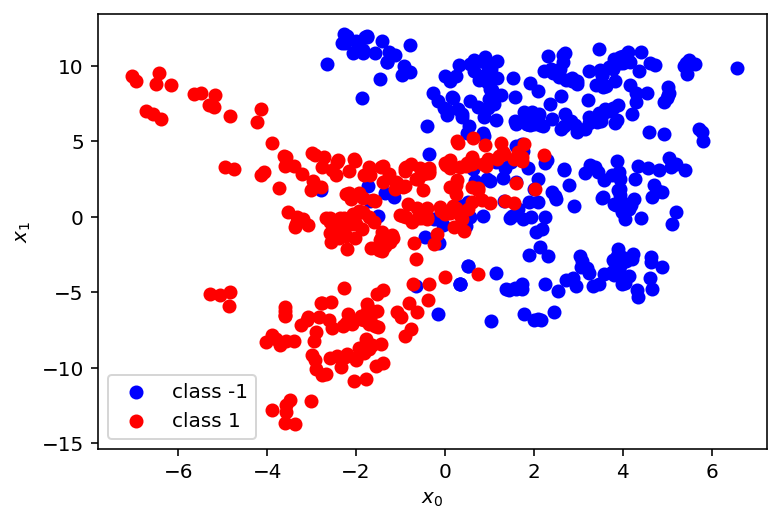

In [5]:
# visualization raw data set
vis(X_shuffled[:,[0,1]], Y_shuffled)

## Classifier #1: Linear SVM with Scikit-Learn

In [6]:
# Calculate error given feature vectors X and labels Y.
def calc_error(X, Y, classifier):
    Y_pred = classifier.predict(X)  # Hint: Use classifier.predict()
    e = accuracy_score(Y, Y_pred)   # Hint: Use accuracy_score().
    return e

In [33]:
def linear_svm(X, Y, X_test=None, Y_test=None):
    C_list = [0.1, 1, 10, 100, 1000]
    opt_e_training = 1.0   # Optimal training error.
    opt_classifier = None  # Optimal classifier.
    opt_C          = None  # Optimal C.

    for C in C_list:
        # Create a linear SVM classifier.
        # Hints: You can use svm.LinearSVC()
        #        Besides, we use Hinge loss and L2 penalty for weights.
        #        The max iterations should be set to 10000.
        #        The regularization parameter should be set as C.
        #        The other arguments of svm.LinearSVC() are set as default values.
        classifier = svm.LinearSVC(penalty='l2', loss='hinge', max_iter=10000, C=C);

        # Use the classifier to fit the training set (use X_train, Y_train).
        # Hint: You can use classifier.fit().
        ######### To be filled. #########
        classifier.fit(X, Y)

        # Obtain the weights and bias from the linear SVM classifier.
        W = classifier.coef_[0]
        b = classifier.intercept_[0]

        # Show decision boundary, training error and test error.
        print('C = {}'.format(C))
        print('Decision boundary: {:.3f}x_0+{:.3f}x_1+{:.3f}=0'.format(W[0],W[1],b))
        vis(X, Y, W, b)
        e_training = calc_error(X, Y, classifier)
        print('Training error: {}'.format(e_training))
        print('\n\n\n')

        # Judge if it is the optimal one.
        if e_training < opt_e_training:
            opt_e_training = e_training
            opt_classifier = classifier
            opt_C = C
            
        if X_test is not None:
            print('Test error: {}'.format(calc_error(X_test, Y_test, opt_classifier)))

## Classifier #2: KNN with Scikit-Learn

In [8]:
# Draw heatmaps for result of grid search.
def draw_heatmap(errors, D_list, title):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
    ax.collections[0].colorbar.set_label('error')
    ax.set(ylabel='k')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title(title)
    plt.show()

In [9]:
def knn_gridsearch(X, Y):
    # Perform grid search for best number of nearest neighbors.

    # 1. Create a k-NN classifier.
    estimator = neighbors.KNeighborsClassifier()

    # 2. Create a grid searcher with 5-fold cross-validation.
    k_list = [1, 2, 3]
    param_grid = {'n_neighbors': k_list}
    grid_search = GridSearchCV(estimator, param_grid, cv=5)

    # 3. Use the grid searcher to fit the training set.
    grid_search.fit(X, Y)
    
    # Draw heatmaps of cross-validation errors (in cross-validation).
    cross_val_errors = 1 - grid_search.cv_results_['mean_test_score'].reshape(-1,1)
    draw_heatmap(cross_val_errors, k_list, title='cross-validation error w.r.t $k$')

In [10]:
def vis2(X, Y, knn_classifier=None):
    # Visualize k-NN.
    if knn_classifier is not None:
        # Calculate min, max and create grids.
        h = .02
        x0_min, x0_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
        x1_min, x1_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
        x0s, x1s = np.meshgrid(np.arange(x0_min, x0_max, h),
                               np.arange(x1_min, x1_max, h))
        xs = np.stack([x0s, x1s], axis=-1).reshape(-1, 2)

        # Predict class using kNN classifier and data.
        ys_pred = np.array([knn_classifier(x) for x in xs])
        ys_pred = ys_pred.reshape(x0s.shape)

        # Put the result into a color plot.
        # Color map: #00AAFF - blue, #FFAAAA - red, #AAFFAA - green
        
        cmap_light = ListedColormap(['#00AAFF', '#FFAAAA'])
        plt.pcolormesh(x0s, x1s, ys_pred, cmap=cmap_light, alpha=0.3)
    
    indices_neg1 = (Y == -1).nonzero()[0]
    indices_pos1 = (Y == 1).nonzero()[0]
    plt.scatter(X[:,0][indices_neg1], X[:,1][indices_neg1], 
                c='blue', label='class -1', alpha=0.3)
    plt.scatter(X[:,0][indices_pos1], X[:,1][indices_pos1], 
                c='red', label='class +1', alpha=0.3)
    plt.legend()
    plt.xlabel('$x_0$')
    plt.ylabel('$x_1$')

    plt.show()

In [11]:
# Euclidean distance.
def calc_distance(x1, x2):
    # x1, x2 are two NumPy vectors
    # Return the Euclidean distance between x1 and x2. It should be a scalar.
    dist = np.sqrt((x1[0] - x2[0])**2 + (x1[1] - x2[1])**2)
    return dist
    
# k nearest neighbor predictor.
def f_knn(x, X_train, Y_train, k):
    # Create the list of (distance, label) pairs.
    dist_label_pairs = []
    for xi, yi in zip(X_train, Y_train):
        # Calculate the distance.
        dist = calc_distance(xi, x)
        # Add a (distance, label) pair to the list.
        dist_label_pairs.append((dist, yi))
    # Sort the pairs by distance (ascending).
    sorted_dist_label_pairs = sorted(dist_label_pairs, key=lambda x:x[0])
    # Obtain the first k pairs (corresponding to k smallest distances).
    k_dist_label_pairs = sorted_dist_label_pairs[0:k]
    # Extract the labels of the k pairs.
    k_labels           = np.array(k_dist_label_pairs)[:,1]
    #print(k_labels)
    # Count the number of +1 predictions and -1 predictions.
    pos1_in_k_labels = 0 
    neg1_in_k_labels = 0
    for label in k_labels:
        if label == +1:
            pos1_in_k_labels += 1
        elif label == -1:
            neg1_in_k_labels += 1
    # Make the prediction based on counts.
    if pos1_in_k_labels > neg1_in_k_labels:
        y_pred = +1
    else:
        y_pred = -1

    return y_pred
    
# Judge function: 1(a != b). It supports scalar, vector and matrix.
def judge(a, b):
    return np.array(a != b).astype(np.float32)

# Calculate error given feature vectors X and labels Y.
def calc_error2(X, Y, knn_classifier):
    e = 0
    n = len(X)
    for (xi, yi) in zip(X, Y):
        e += judge(yi, knn_classifier(xi))
    e = 1.0 * e / n
    return e

In [12]:
def knn_2(X, Y):
    opt_val_error = 1.0
    opt_k = None

    # Try different k(s).
    for k in [1,2,3]:
        # Visualize 
        #   1. Validation set (as points).
        #   2. Decision boundary from training set (as background).
        print("k={}".format(k))
        # Create a k-NN classifier with training set.
        knn_classifier = partial(f_knn, X_train=X, Y_train=Y, k=k)
        # Visualization.
        vis2(X, Y, knn_classifier)
        # Calculate validation error.
        val_error = calc_error2(X, Y, knn_classifier)
        print("Validation error: {}\n".format(val_error))
        if val_error < opt_val_error:
            opt_val_error = val_error
            opt_k = k
            opt_knn_classifier = knn_classifier
            
    return [opt_k, opt_knn_classifier]

## Classifier #3: Decision Tree using Scikit-Learn

In [13]:
def tree_heatmap(errors, D_list, title):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(errors, annot=True, fmt='.3f', yticklabels=D_list, xticklabels=[])
    ax.collections[0].colorbar.set_label('error')
    ax.set(ylabel='max depth D')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title(title)
    plt.show()

In [14]:
def decision_tree(X, Y):    
    # Perform grid search for best max depth.

    # 1. Create a decision tree classifier.
    #    Hint: You can use tree.DecisionTreeClassifier()
    #          We use "entropy" as the criterion. The random state should be
    #          set to 1 for consistent results. Other options are left at default.
    estimator = tree.DecisionTreeClassifier(criterion='entropy', random_state=1)
    # 2. Create a grid searcher with cross-validation.
    D_list = [1, 2, 3, 4, 5]
    param_grid = {'max_depth': D_list}
    #    Hint: You can use GridSearchCV()
    #          Please set a 10-fold cross-validation.
    grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=10)
    # 3. Use the grid searcher to fit the training set.
    #    - This grid searcher will try every max depth in the list. 
    #    - For each max depth, a cross-validation is applied to the training set, 
    #      that is, it creates several (training subset, validation subset) pairs. 
    #      Note: Sometimes the validation subset is called as "test" subset, but it
    #            is not the subset of real test set.
    #        - For each pair, a decision tree classifier will be trained on the 
    #          training subset and evaluated on validation subset.
    #        - The average validation scores will be kept.
    #    
    #    Hint: You can simply use .fit() function of the grid searcher.
    ######## To be filled. ########
    grid_search.fit(X, Y)
    
    cross_val_errors = (1 - grid_search.cv_results_['mean_test_score']).reshape(-1,1)
    tree_heatmap(cross_val_errors, D_list, title='cross-validation error w.r.t D')
    
    # Show the best max depth.
    # Hint: You can use the .best_params_ of the grid searcher 
    #       to obtain the best parameter(s).
    best_max_depth = grid_search.best_params_
    print("Best max depth D: {}".format(best_max_depth))

    # Calculate the test error.
    # Hint: You can use .best_estimator_.predict() to make predictions.
    test_error = 1 - accuracy_score(Y, grid_search.best_estimator_.predict(X))
    print("Test error: {}".format(test_error))

## SPLIT 1: 20% TRAIN / 80% TEST

### Split 1 / Trial 1 / Classifier #1-3

(200, 2)
(200,)
(800, 2)
(800,)
C = 0.1
Decision boundary: -0.605x_0+-0.196x_1+0.274=0
[ 4.882186  -3.7411118]
-3.7411118 4.882186


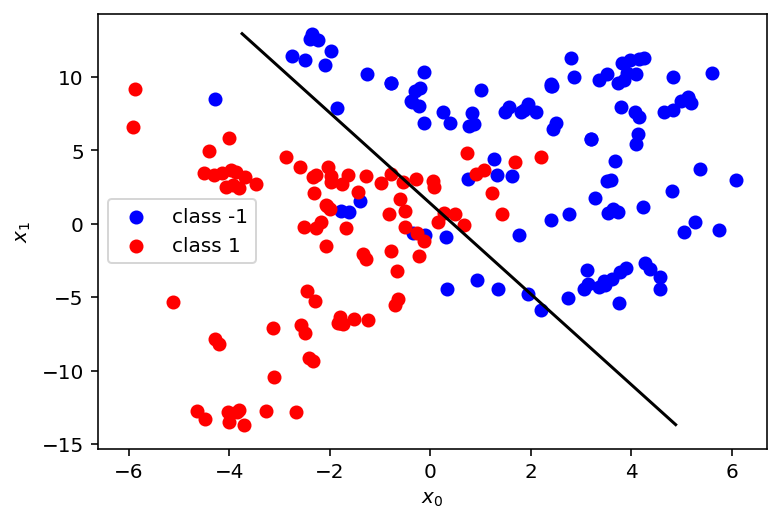

Training error: 0.875




Test error: 0.8725
C = 1
Decision boundary: -0.677x_0+-0.222x_1+0.418=0
[ 5.1021824 -3.630561 ]
-3.630561 5.1021824


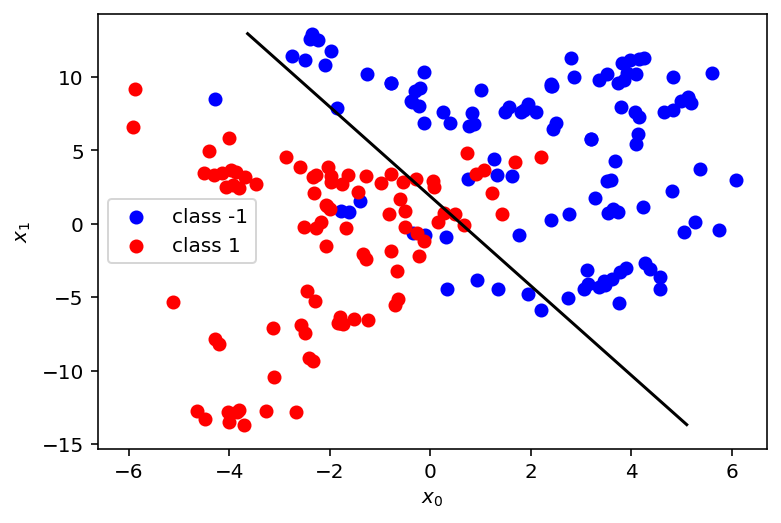

Training error: 0.88




Test error: 0.8725
C = 10
Decision boundary: -0.657x_0+-0.217x_1+0.372=0
[ 5.0745063 -3.7035544]
-3.7035544 5.0745063


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


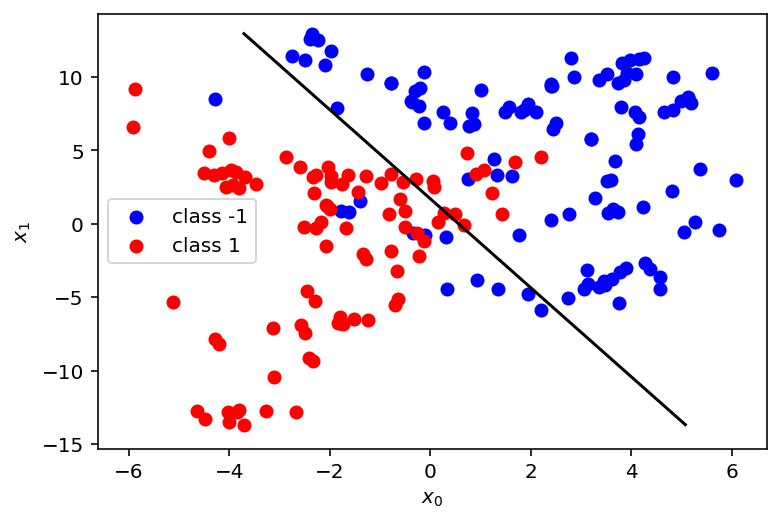

Training error: 0.88




Test error: 0.8725
C = 100
Decision boundary: -0.675x_0+-0.195x_1+0.444=0
[ 4.6127615 -3.0882566]
-3.0882566 4.6127615


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


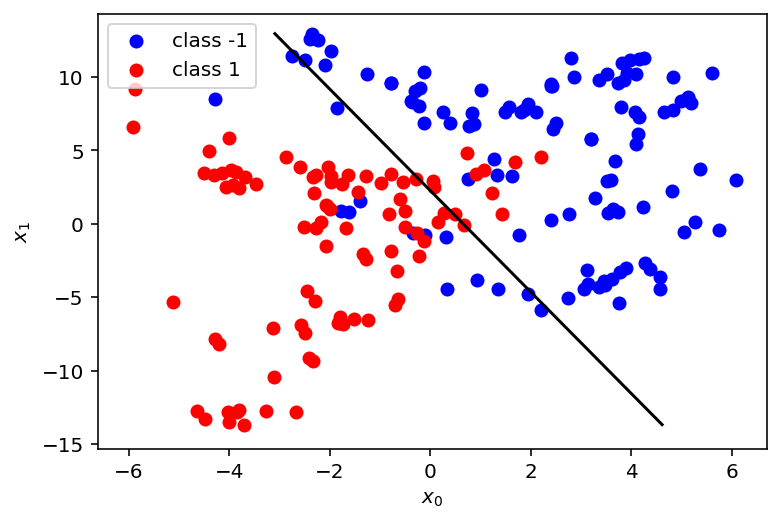

Training error: 0.88




Test error: 0.8725
C = 1000
Decision boundary: -0.370x_0+-0.050x_1+0.687=0
[3.6989217  0.11029804]
0.11029804 3.6989217


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


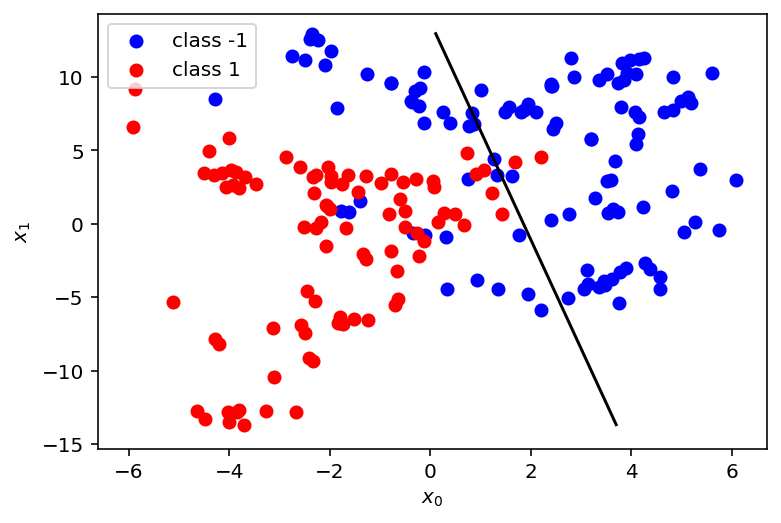

Training error: 0.8




Test error: 0.8125


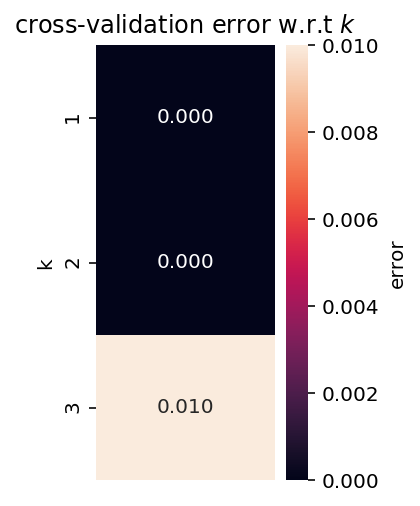

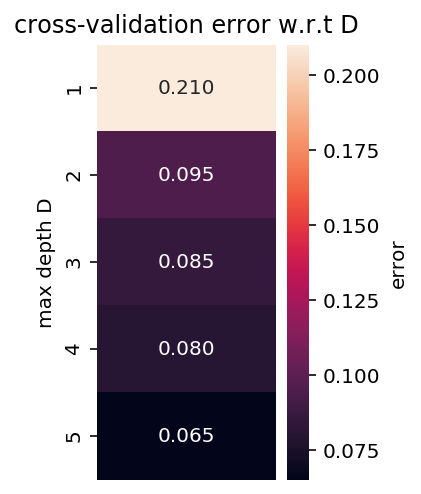

Best max depth D: {'max_depth': 5}
Test error: 0.010000000000000009


In [34]:
# load & shuffle data
X_and_Y = np.loadtxt('data_banknote_authentication.csv', delimiter=',').astype(np.float32) # Load data from file.

np.random.seed(1)                 # Set the random seed.
np.random.shuffle(X_and_Y)        # Shuffle the data.
X_and_Y = X_and_Y[200:1200]
X_shuffled = X_and_Y[:, 0:-1]     # First column to second last column: Features. 
Y_shuffled = X_and_Y[:, -1]       # Last column: Labels.

# Convert labels from {1, 2, 3} to {-1, 1}.
Y_shuffled[Y_shuffled==0] = -1   

# split data
X_train_20 = X_shuffled[:200][:,[0,1]] # Shape: (120,2)

Y_train_20 = Y_shuffled[:200]          # Shape: (120,)

X_test_80 = X_shuffled[200:][:,[0,1]]  # Shape: (480,2)
Y_test_80 = Y_shuffled[200:]          # Shape: (480,)

# Print info 
print(X_train_20.shape)
print(Y_train_20.shape)
print(X_test_80.shape)
print(Y_test_80.shape)

# apply classifier #1
linear_svm(X_train_20, Y_train_20, X_test_80, Y_test_80)

# apply classifier #2
X_train_20 = X_shuffled[:200]         # Shape: (120,2)
Y_train_20 = Y_shuffled[:200]         # Shape: (120,)

knn_gridsearch(X_train_20, Y_train_20)

# apply classifier #3
decision_tree(X_train_20, Y_train_20)



### Split 1 / Trial 2 / Classifier #1-3

(200, 2)
(200,)
(800, 2)
(800,)
C = 0.1
Decision boundary: -0.625x_0+-0.132x_1+0.347=0
[ 3.4354491 -2.1761398]
-2.1761398 3.4354491


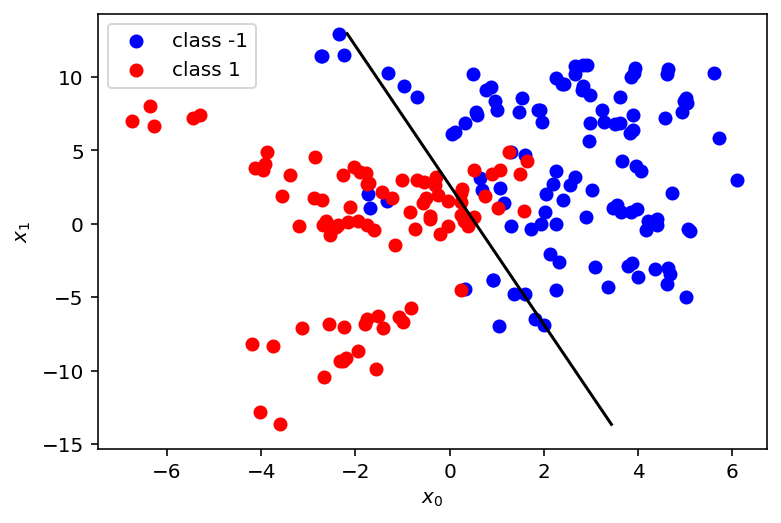

Training error: 0.875




Test error: 0.88125
C = 1
Decision boundary: -0.727x_0+-0.169x_1+0.406=0
[ 3.7401123 -2.458401 ]
-2.458401 3.7401123


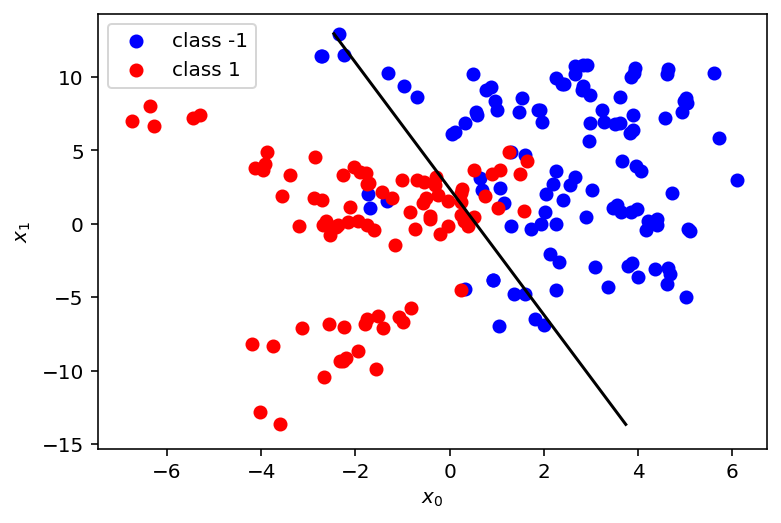

Training error: 0.865




Test error: 0.89
C = 10
Decision boundary: -0.727x_0+-0.169x_1+0.406=0
[ 3.738753  -2.4568107]
-2.4568107 3.738753


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


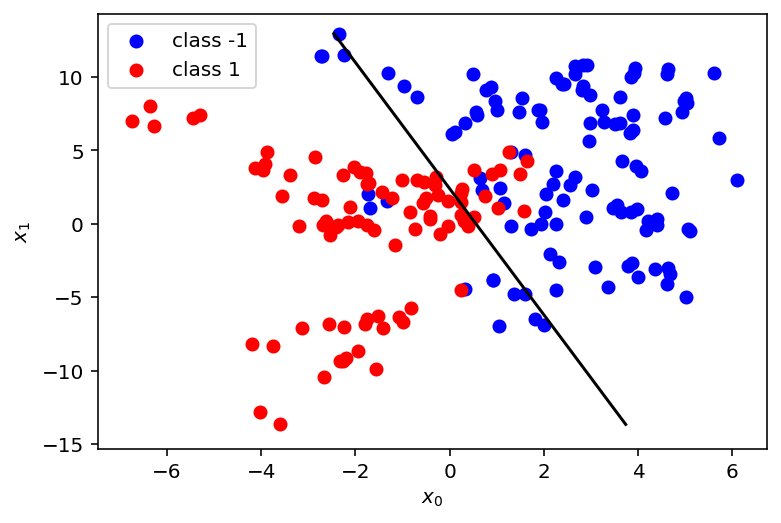

Training error: 0.865




Test error: 0.89
C = 100
Decision boundary: -0.773x_0+-0.157x_1+0.471=0
[ 3.3911166 -2.028657 ]
-2.028657 3.3911166


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


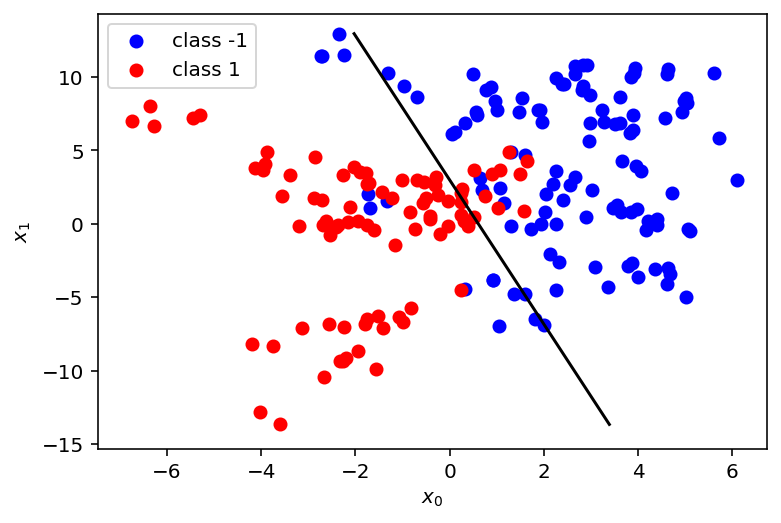

Training error: 0.875




Test error: 0.89
C = 1000
Decision boundary: -0.820x_0+-0.267x_1+0.677=0
[ 5.2753124 -3.3936894]
-3.3936894 5.2753124


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


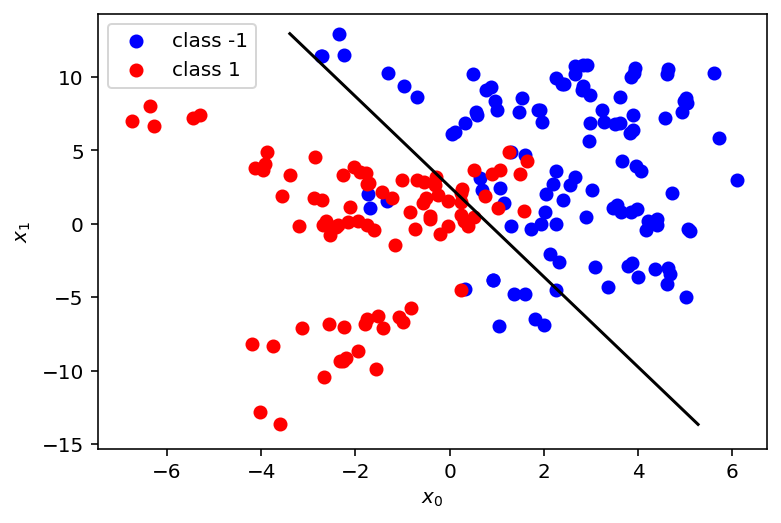

Training error: 0.885




Test error: 0.89


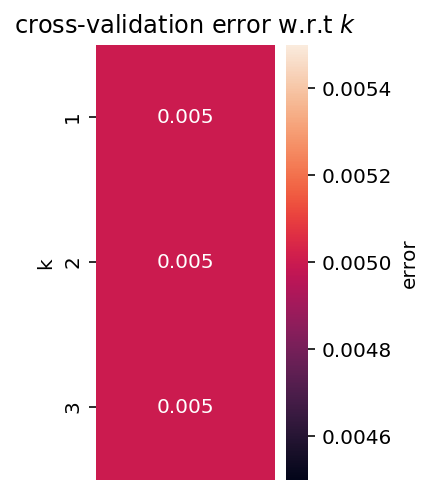

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


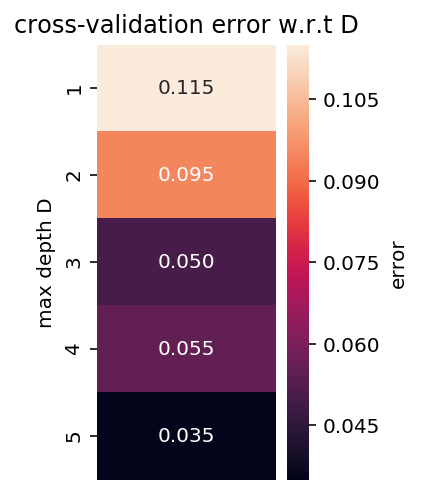

Best max depth D: {'max_depth': 5}
Test error: 0.020000000000000018


In [35]:
# load & shuffle data
X_and_Y = np.loadtxt('data_banknote_authentication.csv', delimiter=',').astype(np.float32) # Load data from file.

np.random.seed(2)                 # Set the random seed.
np.random.shuffle(X_and_Y)        # Shuffle the data.
X_and_Y = X_and_Y[200:1200]
X_shuffled = X_and_Y[:, 0:-1]     # First column to second last column: Features. 
Y_shuffled = X_and_Y[:, -1]       # Last column: Labels.

# Convert labels from {1, 2, 3} to {-1, 1}.
Y_shuffled[Y_shuffled==0] = -1   

# split data
X_train_20 = X_shuffled[:200][:,[0,1]] # Shape: (120,2)

Y_train_20 = Y_shuffled[:200]          # Shape: (120,)

X_test_80 = X_shuffled[200:][:,[0,1]]  # Shape: (480,2)
Y_test_80 = Y_shuffled[200:]          # Shape: (480,)

# Print info 
print(X_train_20.shape)
print(Y_train_20.shape)
print(X_test_80.shape)
print(Y_test_80.shape)

# apply classifier #1
linear_svm(X_train_20, Y_train_20, X_test_80, Y_test_80)

# apply classifier #2
X_train_20 = X_shuffled[:200]         # Shape: (120,2)
Y_train_20 = Y_shuffled[:200]         # Shape: (120,)

knn_gridsearch(X_train_20, Y_train_20)

# apply classifier #3
decision_tree(X_train_20, Y_train_20)



### Split 1 / Trial 3 / Classifier #1-3

(200, 2)
(200,)
(800, 2)
(800,)
C = 0.1
Decision boundary: -0.560x_0+-0.175x_1+0.065=0
[ 4.4101167 -3.7811816]
-3.7811816 4.4101167


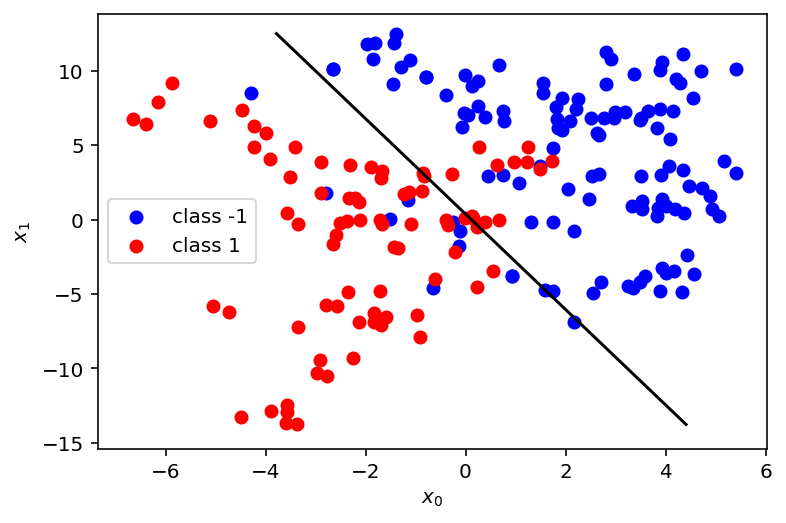

Training error: 0.875




Test error: 0.86125
C = 1
Decision boundary: -0.654x_0+-0.202x_1+0.228=0
[ 4.611222  -3.5207093]
-3.5207093 4.611222


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


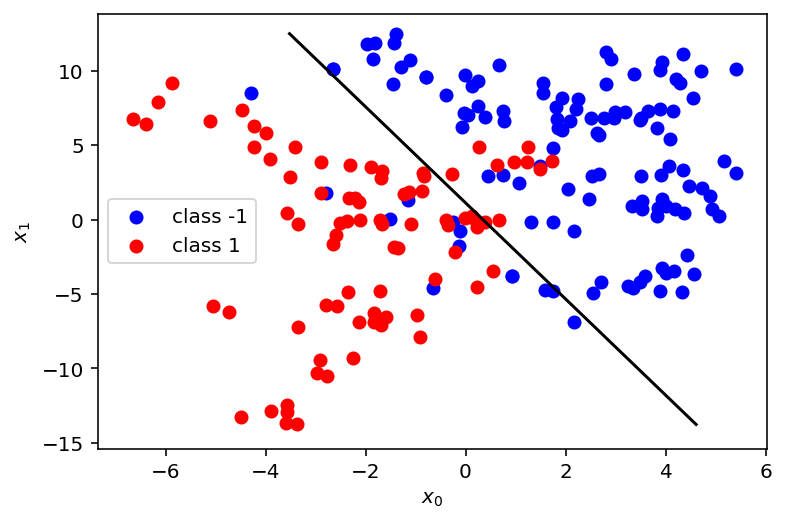

Training error: 0.89




Test error: 0.86125
C = 10
Decision boundary: -0.653x_0+-0.202x_1+0.230=0
[ 4.6256065 -3.5256548]
-3.5256548 4.6256065


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


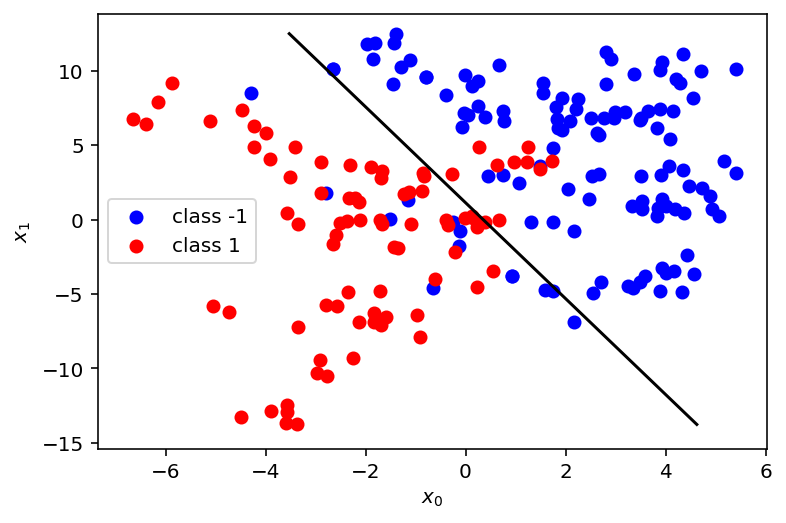

Training error: 0.89




Test error: 0.86125
C = 100
Decision boundary: -0.672x_0+-0.154x_1+0.267=0
[ 3.5611935 -2.475684 ]
-2.475684 3.5611935


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


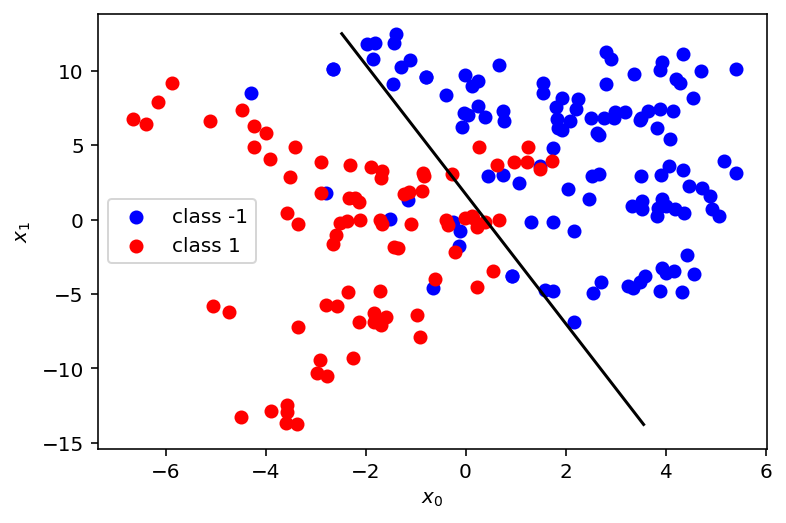

Training error: 0.895




Test error: 0.86125
C = 1000
Decision boundary: -0.457x_0+0.203x_1+0.538=0
[-4.9390798  6.726935 ]
-4.9390798 6.726935


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


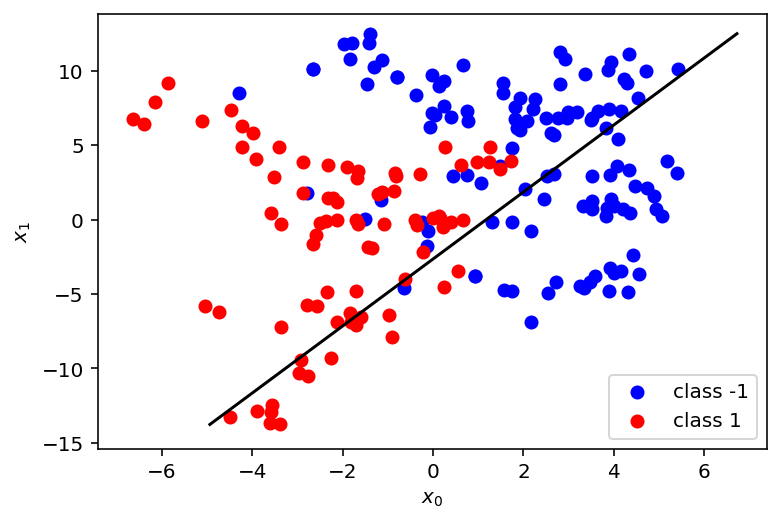

Training error: 0.555




Test error: 0.59625


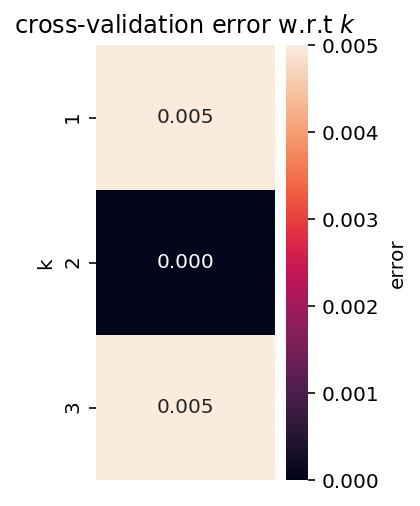

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


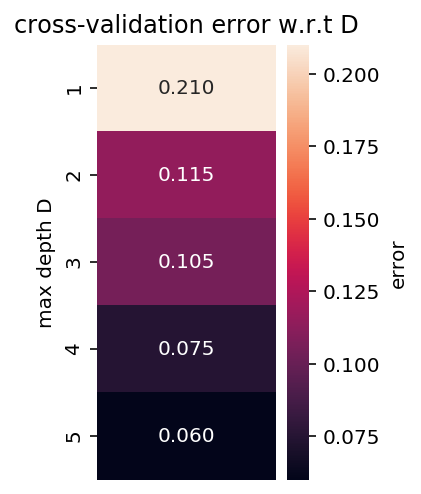

Best max depth D: {'max_depth': 5}
Test error: 0.010000000000000009


In [36]:
# load & shuffle data
X_and_Y = np.loadtxt('data_banknote_authentication.csv', delimiter=',').astype(np.float32) # Load data from file.

np.random.seed(3)                 # Set the random seed.
np.random.shuffle(X_and_Y)        # Shuffle the data.
X_and_Y = X_and_Y[200:1200]
X_shuffled = X_and_Y[:, 0:-1]     # First column to second last column: Features. 
Y_shuffled = X_and_Y[:, -1]       # Last column: Labels.

# Convert labels from {1, 2, 3} to {-1, 1}.
Y_shuffled[Y_shuffled==0] = -1   

# split data
X_train_20 = X_shuffled[:200][:,[0,1]] # Shape: (120,2)

Y_train_20 = Y_shuffled[:200]          # Shape: (120,)

X_test_80 = X_shuffled[200:][:,[0,1]]  # Shape: (480,2)
Y_test_80 = Y_shuffled[200:]          # Shape: (480,)

# Print info 
print(X_train_20.shape)
print(Y_train_20.shape)
print(X_test_80.shape)
print(Y_test_80.shape)

# apply classifier #1
linear_svm(X_train_20, Y_train_20, X_test_80, Y_test_80)

# apply classifier #2
X_train_20 = X_shuffled[:200]         # Shape: (120,2)
Y_train_20 = Y_shuffled[:200]         # Shape: (120,)

knn_gridsearch(X_train_20, Y_train_20)

# apply classifier #3
decision_tree(X_train_20, Y_train_20)



# -------------------------------------------------------------

## SPLIT 2: 80% TRAIN / 20% TEST

### Split 2 / Trial 1 / Classifier #1-3

(800, 2)
(800,)
(200, 2)
(200,)
C = 0.1
Decision boundary: -0.658x_0+-0.191x_1+0.315=0
[ 4.4780135 -3.2806716]
-3.2806716 4.4780135


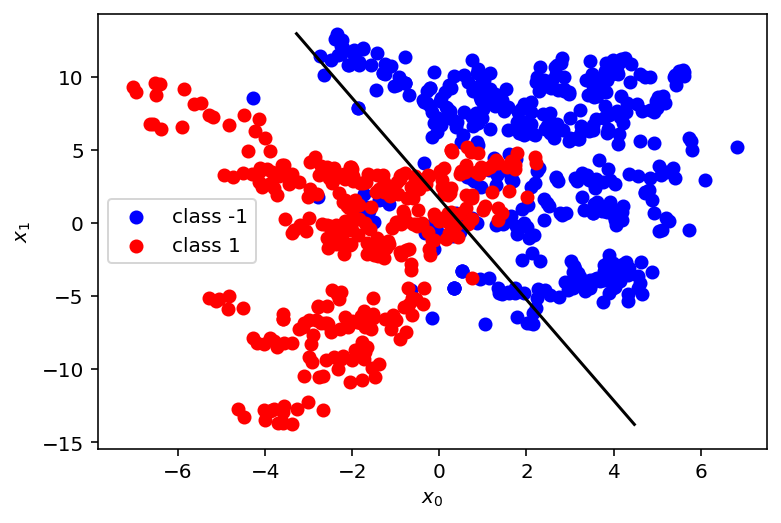

Training error: 0.8775




Test error: 0.885
C = 1
Decision boundary: -0.680x_0+-0.198x_1+0.359=0
[ 4.5324154 -3.237822 ]
-3.237822 4.5324154


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


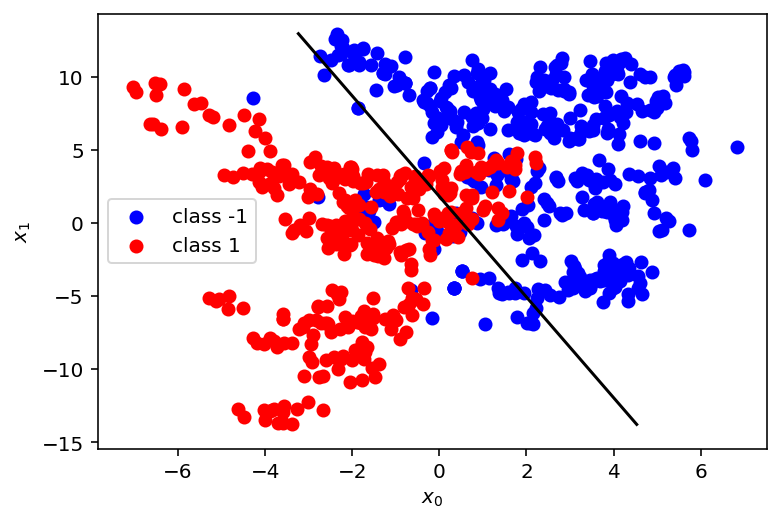

Training error: 0.8775




Test error: 0.885
C = 10
Decision boundary: -0.666x_0+-0.198x_1+0.380=0
[ 4.6690392 -3.2833776]
-3.2833776 4.6690392


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


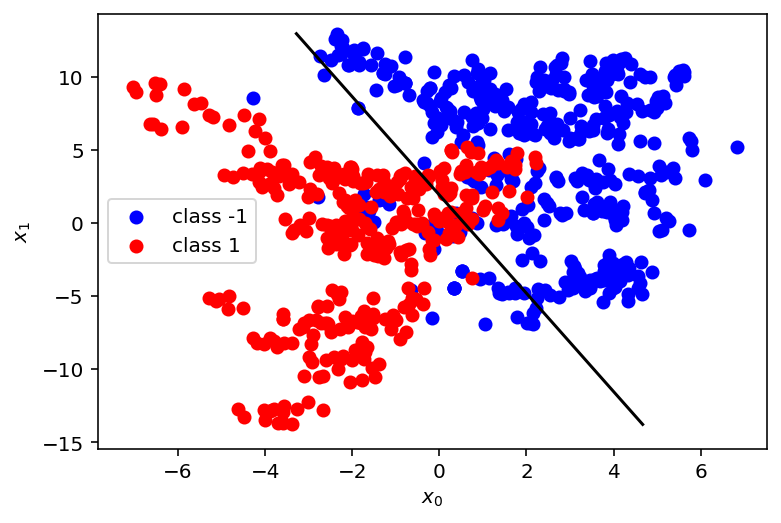

Training error: 0.87375




Test error: 0.88
C = 100
Decision boundary: -0.681x_0+-0.154x_1+0.332=0
[ 3.6051888 -2.445632 ]
-2.445632 3.6051888


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


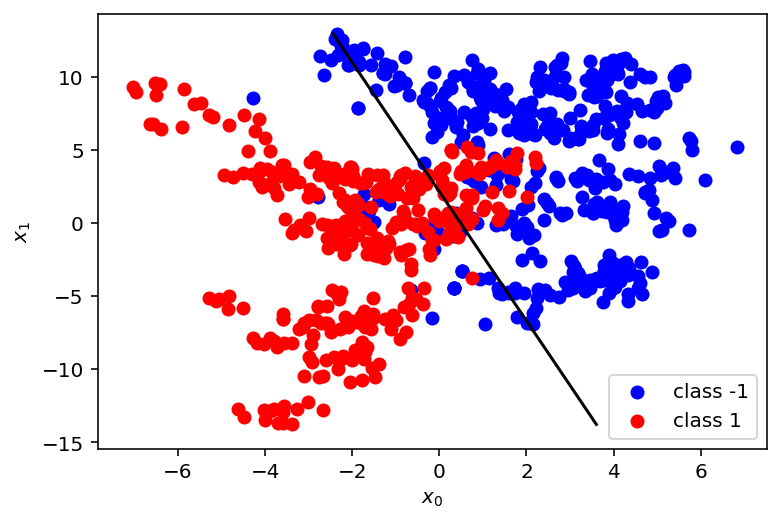

Training error: 0.88




Test error: 0.88
C = 1000
Decision boundary: -0.869x_0+-0.263x_1+0.405=0
[ 4.632542  -3.4511619]
-3.4511619 4.632542


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


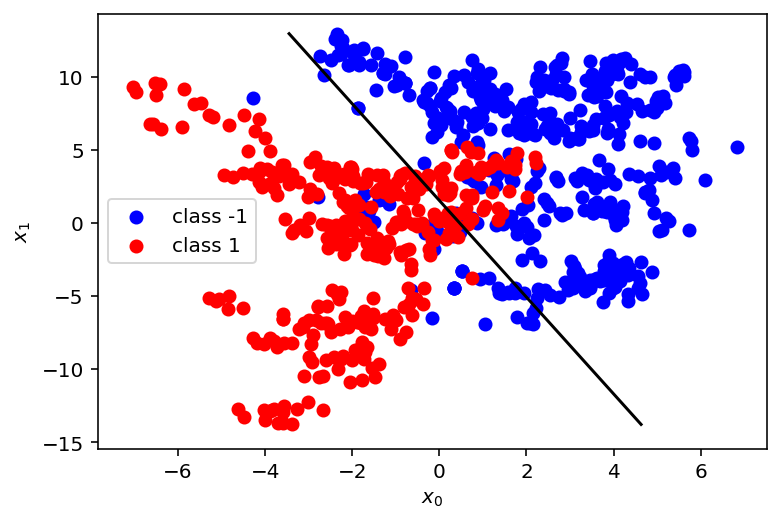

Training error: 0.875




Test error: 0.88


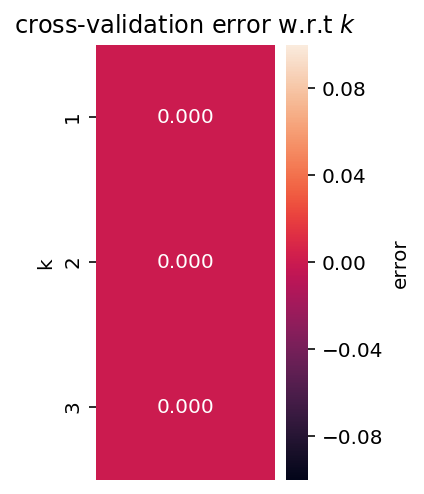

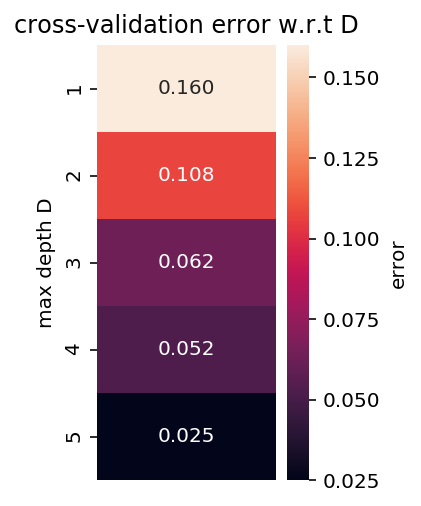

Best max depth D: {'max_depth': 5}
Test error: 0.0050000000000000044


In [39]:
# load & shuffle data
X_and_Y = np.loadtxt('data_banknote_authentication.csv', delimiter=',').astype(np.float32) # Load data from file.

np.random.seed(1)                 # Set the random seed.
np.random.shuffle(X_and_Y)        # Shuffle the data.
X_and_Y = X_and_Y[200:1200]
X_shuffled = X_and_Y[:, 0:-1]     # First column to second last column: Features. 
Y_shuffled = X_and_Y[:, -1]       # Last column: Labels.

# Convert labels from {1, 2, 3} to {-1, 1}.
Y_shuffled[Y_shuffled==0] = -1    

# split data
X_train_80 = X_shuffled[:800][:,[0,1]] # Shape: (480,2)
Y_train_80 = Y_shuffled[:800]          # Shape: (480,)

X_test_20 = X_shuffled[800:][:,[0,1]]  # Shape: (120,2)
Y_test_20 = Y_shuffled[800:]           # Shape: (120,)

# Print info 
print(X_train_80.shape)
print(Y_train_80.shape)
print(X_test_20.shape)
print(Y_test_20.shape)

# apply classifier #1
linear_svm(X_train_80, Y_train_80, X_test_20, Y_test_20)

# apply classifier #2
X_train_80 = X_shuffled[:800]         # Shape: (480,2)
Y_train_80 = Y_shuffled[:800]         # Shape: (480,)

knn_gridsearch(X_train_80, Y_train_80)

# apply classifier #3
decision_tree(X_train_80, Y_train_80)


### Split 2 / Trial 2 / Classifier #1-3

(800, 2)
(800,)
(200, 2)
(200,)
C = 0.1
Decision boundary: -0.682x_0+-0.218x_1+0.445=0
[ 5.019071  -3.4805572]
-3.4805572 5.019071


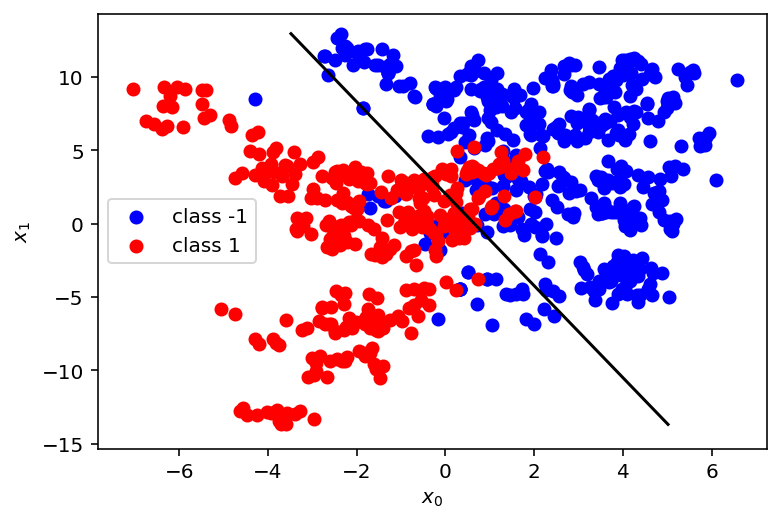

Training error: 0.8875




Test error: 0.875
C = 1
Decision boundary: -0.694x_0+-0.227x_1+0.484=0
[ 5.1714377 -3.5382266]
-3.5382266 5.1714377


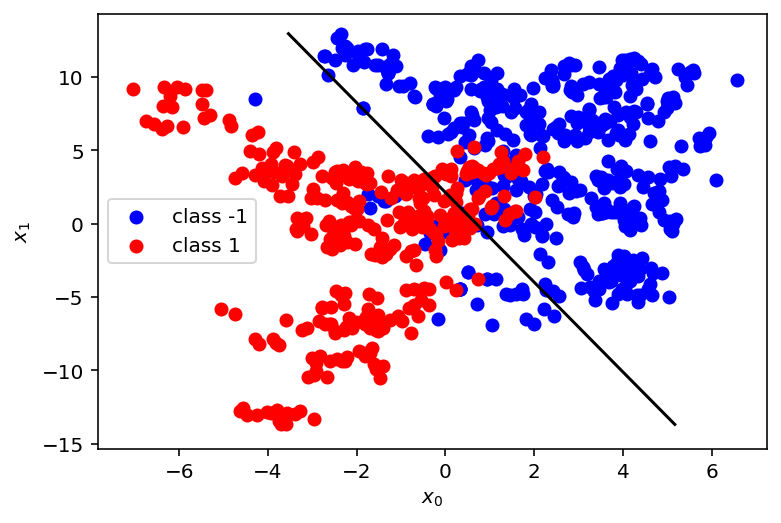

Training error: 0.88875




Test error: 0.875
C = 10
Decision boundary: -0.696x_0+-0.228x_1+0.489=0
[ 5.1806197 -3.5386415]
-3.5386415 5.1806197


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


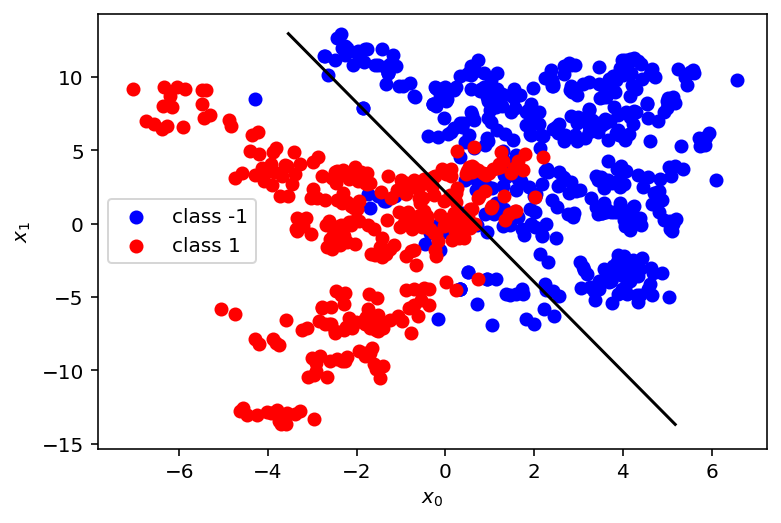

Training error: 0.88875




Test error: 0.875
C = 100
Decision boundary: -0.632x_0+-0.245x_1+0.537=0
[ 6.149197  -4.1683726]
-4.1683726 6.149197


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


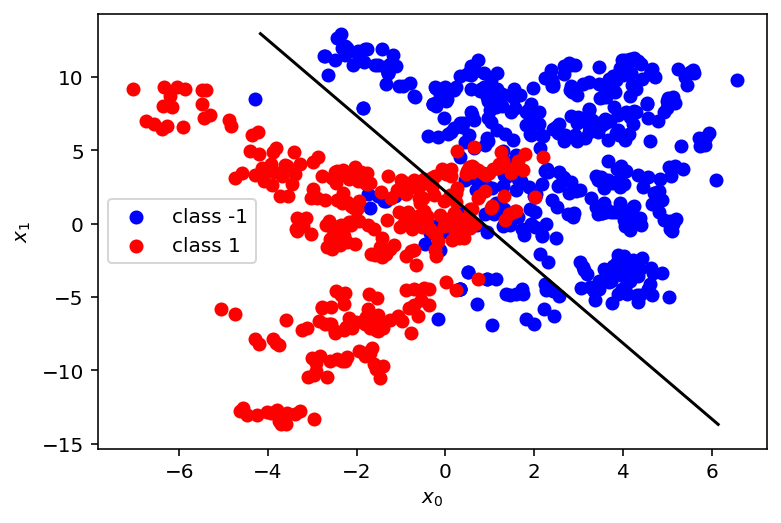

Training error: 0.88375




Test error: 0.865
C = 1000
Decision boundary: -0.469x_0+-0.306x_1+0.543=0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[10.093677 -7.301401]
-7.0421 10.093677


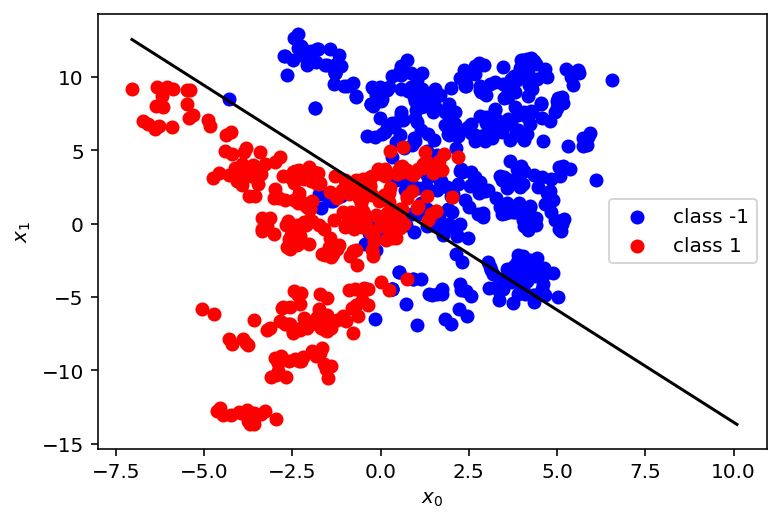

Training error: 0.85125




Test error: 0.82


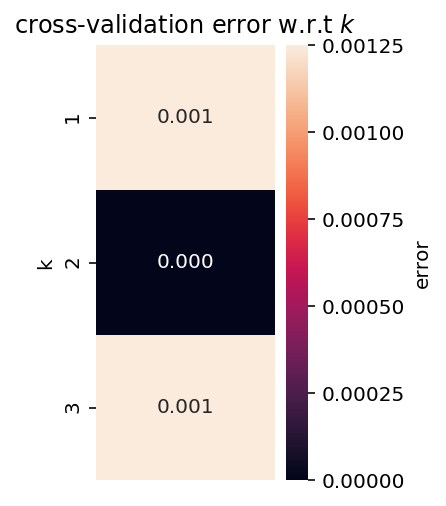

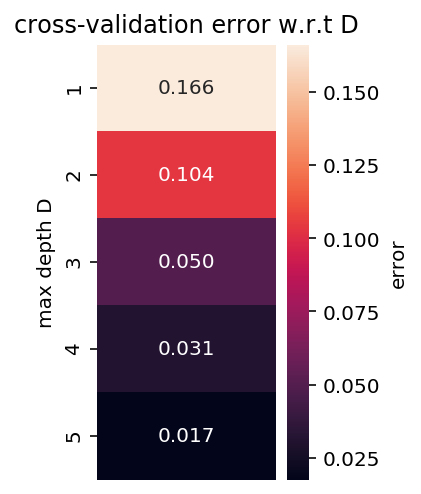

Best max depth D: {'max_depth': 5}
Test error: 0.015000000000000013


In [37]:
# load & shuffle data
X_and_Y = np.loadtxt('data_banknote_authentication.csv', delimiter=',').astype(np.float32) # Load data from file.

np.random.seed(2)                 # Set the random seed.
np.random.shuffle(X_and_Y)        # Shuffle the data.
X_and_Y = X_and_Y[200:1200]
X_shuffled = X_and_Y[:, 0:-1]     # First column to second last column: Features. 
Y_shuffled = X_and_Y[:, -1]       # Last column: Labels.

# Convert labels from {1, 2, 3} to {-1, 1}.
Y_shuffled[Y_shuffled==0] = -1    

# split data
X_train_80 = X_shuffled[:800][:,[0,1]] # Shape: (480,2)
Y_train_80 = Y_shuffled[:800]          # Shape: (480,)

X_test_20 = X_shuffled[800:][:,[0,1]]  # Shape: (120,2)
Y_test_20 = Y_shuffled[800:]           # Shape: (120,)

# Print info 
print(X_train_80.shape)
print(Y_train_80.shape)
print(X_test_20.shape)
print(Y_test_20.shape)

# apply classifier #1
linear_svm(X_train_80, Y_train_80, X_test_20, Y_test_20)


# apply classifier #2
X_train_80 = X_shuffled[:800]         # Shape: (480,2)
Y_train_80 = Y_shuffled[:800]         # Shape: (480,)

knn_gridsearch(X_train_80, Y_train_80)

# apply classifier #3
decision_tree(X_train_80, Y_train_80)


### Split 2 / Trial 3 / Classifier #1-3

(800, 2)
(800,)
(200, 2)
(200,)
C = 0.1
Decision boundary: -0.625x_0+-0.187x_1+0.332=0
[ 4.657797  -3.3486366]
-3.3486366 4.657797


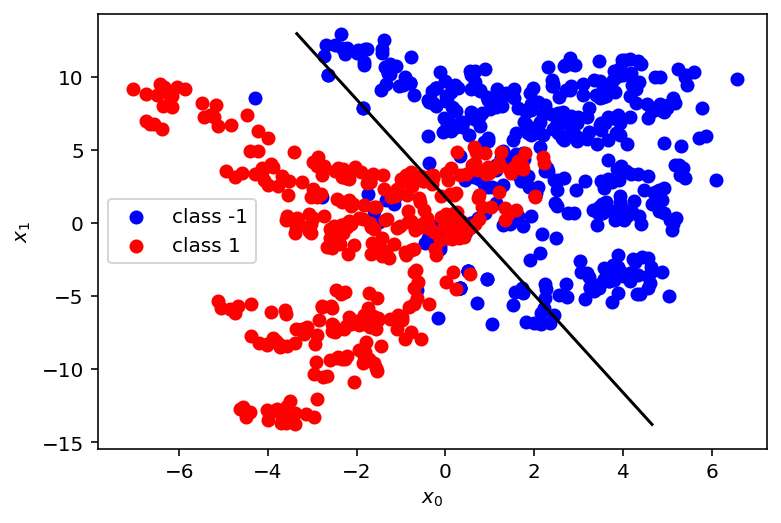

Training error: 0.87625




Test error: 0.885
C = 1
Decision boundary: -0.667x_0+-0.200x_1+0.421=0
[ 4.755442  -3.2477598]
-3.2477598 4.755442


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


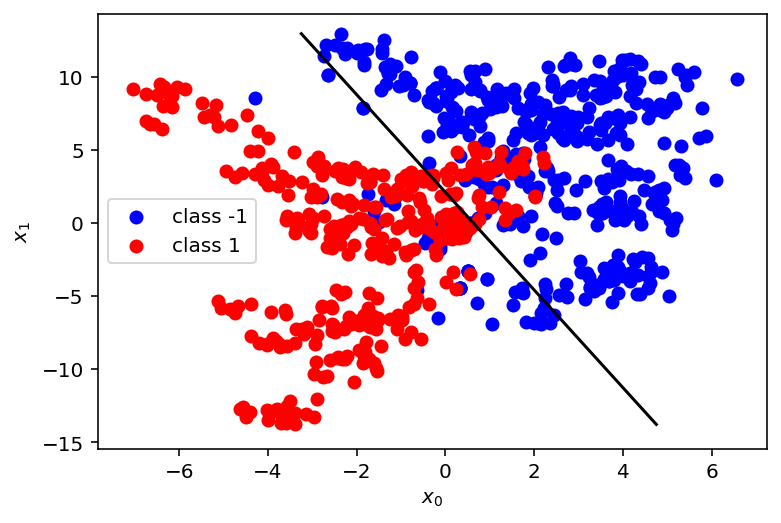

Training error: 0.875




Test error: 0.865
C = 10
Decision boundary: -0.672x_0+-0.203x_1+0.425=0
[ 4.7892175 -3.275365 ]
-3.275365 4.7892175


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


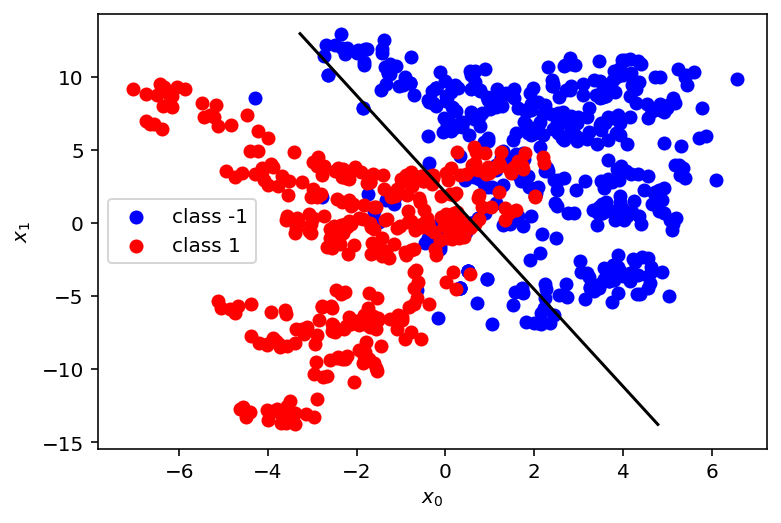

Training error: 0.875




Test error: 0.865
C = 100
Decision boundary: -0.662x_0+-0.184x_1+0.432=0
[ 4.475444  -2.9418523]
-2.9418523 4.475444


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


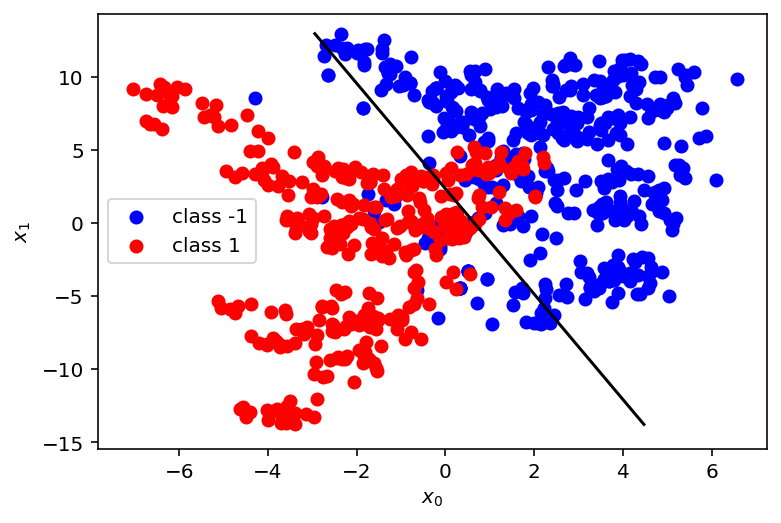

Training error: 0.88




Test error: 0.865
C = 1000
Decision boundary: -0.697x_0+0.064x_1+0.402=0
[-0.68529147  1.7644308 ]
-0.68529147 1.7644308


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


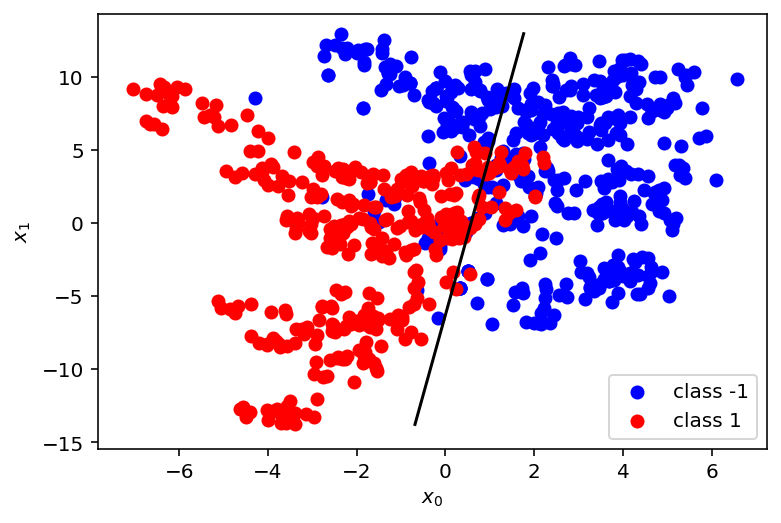

Training error: 0.805




Test error: 0.855


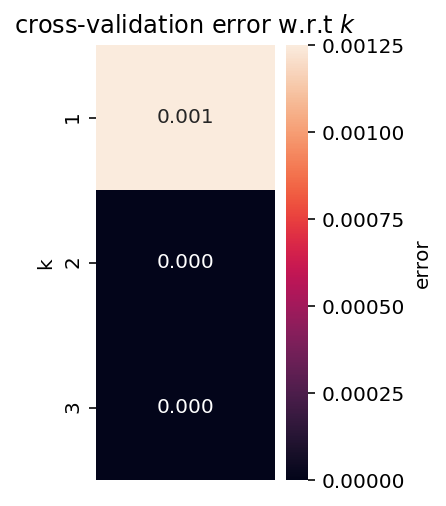

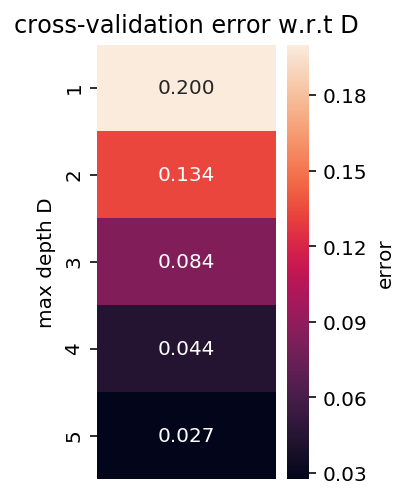

Best max depth D: {'max_depth': 5}
Test error: 0.008750000000000036


In [38]:
# load & shuffle data
X_and_Y = np.loadtxt('data_banknote_authentication.csv', delimiter=',').astype(np.float32) # Load data from file.

np.random.seed(3)                 # Set the random seed.
np.random.shuffle(X_and_Y)        # Shuffle the data.
X_and_Y = X_and_Y[200:1200]
X_shuffled = X_and_Y[:, 0:-1]     # First column to second last column: Features. 
Y_shuffled = X_and_Y[:, -1]       # Last column: Labels.

# Convert labels from {1, 2, 3} to {-1, 1}.
Y_shuffled[Y_shuffled==0] = -1    

# split data
X_train_80 = X_shuffled[:800][:,[0,1]] # Shape: (480,2)
Y_train_80 = Y_shuffled[:800]          # Shape: (480,)

X_test_20 = X_shuffled[800:][:,[0,1]]  # Shape: (120,2)
Y_test_20 = Y_shuffled[800:]           # Shape: (120,)

# Print info 
print(X_train_80.shape)
print(Y_train_80.shape)
print(X_test_20.shape)
print(Y_test_20.shape)

# apply classifier #1
linear_svm(X_train_80, Y_train_80, X_test_20, Y_test_20)

# apply classifier #2
X_train_80 = X_shuffled[:800]         # Shape: (480,2)
Y_train_80 = Y_shuffled[:800]         # Shape: (480,)

knn_gridsearch(X_train_80, Y_train_80)

# apply classifier #3
decision_tree(X_train_80, Y_train_80)
